## Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import time
import pylab as pl
import gmsh
from IPython import display
from matplotlib.path import Path
from scipy.sparse import coo_array
from collections import Counter
%matplotlib inline
import scipy
import time
from multiprocessing import Manager,Pool
from worker1 import matrix_helper
from worker2 import picard_helper
import gc

## Utility functions

In [3]:
def createMesh(geo_file,meshFactorForEntireSurface,meshFactorForAdaptiveSurface=None,xSource=None,ySource=None,isMeshRectangle=False):
    '''Create Mesh File'''
    gmsh.initialize()
    gmsh.open(geo_file)
    if isMeshRectangle:
        gmsh.model.mesh.MeshSizeExtendFromBoundary = 0;
        gmsh.model.mesh.MeshSizeFromPoints = 0;
        gmsh.model.mesh.MeshSizeFromCurvature = 0;
        lenghtofAdaptiveSurface = 6 #mm
        gmsh.model.mesh.field.add("Box", 1)
        gmsh.model.mesh.field.setNumber(1, "VOut", meshFactorForEntireSurface)
        gmsh.option.setNumber("Mesh.MeshSizeFromPoints", 0)
        gmsh.option.setNumber("Mesh.MeshSizeExtendFromBoundary", 0)
        gmsh.model.mesh.field.setNumber(1, "VIn", meshFactorForAdaptiveSurface)     
        gmsh.model.mesh.field.setNumber(1, "XMax", min(xSource + lenghtofAdaptiveSurface,100)) 
        gmsh.model.mesh.field.setNumber(1, "XMin", max(xSource - lenghtofAdaptiveSurface,0)) 
        gmsh.model.mesh.field.setNumber(1, "YMax", min(ySource + lenghtofAdaptiveSurface,50)) 
        gmsh.model.mesh.field.setNumber(1, "YMin", max(ySource - lenghtofAdaptiveSurface,0))  
        # Apply the combined field as a background mesh
        gmsh.model.mesh.field.setAsBackgroundMesh(1)
    else:
        gmsh.option.setNumber("Mesh.MeshSizeFactor", meshFactorForEntireSurface)
    gmsh.model.mesh.generate(2)
    mesh_filename = 'Mesh.msh'
    gmsh.write(mesh_filename)
    gmsh.finalize()
    return read_mesh(mesh_filename)

def read_mesh(filepath):
    '''
    Takes in an msh file and should return nodal coordinates and element connectivity in each physical group along with the boundary nodes 
    '''
    gmsh.initialize()
    gmsh.open(filepath)
    print(f"Reading {filepath}")
    print(f"Number of nodes in the mesh: {int(gmsh.option.getNumber('Mesh.NbNodes'))}")
    print(f"Number of triangles in the mesh: {int(gmsh.option.getNumber('Mesh.NbTriangles'))}\n")

    #Get all nodes
    dim = -1
    tag = -1
    nodeTags, nodecoords, _ = gmsh.model.mesh.getNodes(dim,tag)
    nodecoords = nodecoords.reshape(-1,3) #tags start from 1

    #Get all triangles
    eleType = 2
    tag = -1
    elements_t,ele_con = gmsh.model.mesh.getElementsByType(eleType,-1)
    ele_con = ele_con.reshape(-1,3)  #tags start from 1

    gmsh.finalize()
    return [nodecoords,ele_con] 

In [4]:
''' Functions relating to source term and the properties of Titanium alloy '''
def Q(point,centre,ro):
    x = point[0,0] - centre[0,0]
    y = point[0,1] - centre[0,1]
    Qo = 5 ## amplitude in W/mm^2 
    return Qo*np.exp(-(x**2+y**2)/ro**2)  ## W/m^3

def rho_Ti(T, phase = 'alpha'):
    if phase == 'alpha':
        return -5.13e-5*(T**2)-0.01935*T+4451
    elif phase == 'beta':
        return -2.762e-6*(T**2)-0.1663*T+4468
    elif phase == 'liquid':
        return -0.565*T+5093
    else:
        return T

def cp_Ti(T,phase = 'alpha'):
    if phase == 'alpha':
        return 0.25*T+483
    elif phase == 'beta':
        return 0.14*T+530
    elif phase == 'liquid':
        return 930
    else:
        return T

def k_Ti(T,phase = 'alpha'):
    if phase == 'alpha':
        return 0.012*T+3.3
    elif phase == 'beta':
        return 0.016*T-3
    elif phase == 'liquid':
        return 0.0175*T-4.5
    else:
        return T

def props_chooser(T, T_rep, process = 'heating'):
    if (T_rep<1268 and process == 'heating') or (T_rep<=1073 and process == 'cooling'):
        return rho_Ti(T,phase = 'alpha'),cp_Ti(T,phase = 'alpha'),k_Ti(T,phase = 'alpha')
    elif (T_rep<1928 and process == 'heating') or (T_rep>1073 and process == 'cooling'):
        return rho_Ti(T,phase = 'beta'),cp_Ti(T,phase = 'beta'),k_Ti(T,phase = 'beta')
    elif (T_rep>=1928 and process == 'heating') or (T_rep>=1878 and process == 'cooling'):
        return rho_Ti(T,phase = 'liquid'),cp_Ti(T,phase = 'liquid'),k_Ti(T,phase = 'liquid')
    else:
        return -1
  

In [5]:
'''Parallel processing utility functions'''
def flatten(xss):
    return [x for xs in xss for x in xs] 

## Validation of quasi-static solver code

In [21]:
class FEM:
    def __init__(self,nodecoords,elecon,centre):
        self.data_line = {"ips":{2:[-1/np.sqrt(3),1/np.sqrt(3)],3:[-np.sqrt(3/5),0,np.sqrt(3/5)]},\
        "weights":{2:[1,1],3:[5/9,8/9,5/9]}}
        self.data_tle = {"ips":{1:[[1/3,1/3]],3:[[1/6,1/6],[1/6,2/3],[2/3,1/6]]},\
       "weights":{1:[1/2],3:[1/6,1/6,1/6]}}
        self.nodecoords = nodecoords
        self.elecon = elecon
        self.centre = centre
    
    def fit_ele(self,theta_prev_time = None,theta_prev_pic = None,mode = "linear",verbose = False):
        '''
        Return mass and stiffness matrices alongside the forcing vector
        '''

        nodes = self.nodecoords
        ele = self.elecon
        source = self.centre

        #getting the boundary nodes
        
        ln = np.where(nodes[:,0] == 0)[0]
        rn = np.where(nodes[:,0] == np.max(nodes[:,0]))[0]
        bn = np.where(nodes[:,1] == 0)[0]
        tn = np.where(nodes[:,1] == np.max(nodes[:,1]))[0]

        #Data for FEA
        gp = 3
        nop = nodes.shape[0]
        ips = np.array(self.data_tle["ips"][gp])
        weights = np.array(self.data_tle["weights"][gp])

        K_row,K_col,K_data = [],[],[]
        G_row,G_col,G_data = [],[],[]

        #Parallel processing for matrix computations
        items = [(nodes,elei,source,theta_prev_time,theta_prev_pic,mode) for elei in ele]
        st = time.time()
        with Pool(processes = 4) as pool:
            results = pool.map(matrix_helper, items)
        if verbose == True:
            print(f"Time for pooling to end {time.time()-st}")

        #Accumulating data collected over multiprocessing
        st = time.time()
        K_row, K_col, K_data, G_row, G_col, G_data, F_row,F_data, BT_row, BT_data,areas = list(zip(*results))
        mega = [K_row, K_col, K_data, G_row, G_col, G_data, F_row,F_data, BT_row, BT_data]
        K_row, K_col, K_data, G_row, G_col, G_data, F_row,F_data, BT_row, BT_data = [flatten(mini) for mini in mega]
        if verbose == True:
            print(f"Time for accumulation of data to end {time.time()-st}")

        h = np.sqrt(np.mean(areas)) 
        if verbose == True:
            print(f"Mesh size is {h} mm")
            print(f"Spot radius is 2 mm")

        #Preparing the matrices for calculations
        st = time.time()
        F= coo_array((F_data,(F_row,[0]*len(F_row))),shape = ((nop,1))).toarray()
        boundary_term = coo_array((BT_data,(BT_row,[0]*len(BT_row))),shape = ((nop,1))).toarray()
        
        K_sparse = coo_array((K_data,(K_row,K_col)),shape=(nop,nop))
        G_sparse = coo_array((G_data,(G_row,G_col)),shape=(nop,nop))
        if verbose == True:
            print(f"Time for matrices creation {time.time()-st}")

        #Converting sparse to dense matrix for submatrix extractions
        st = time.time()
        K = K_sparse.toarray()
        G = G_sparse.toarray()

        if mode == "no_source":
            F = np.zeros((nop,1))
            G = np.zeros((nop,nop))
        if verbose == True:
            print(f"Time for sparse to dense conversion {time.time()-st}")

        #Setting up the right hand side by subtracting the dirichlet terms
        T_l = 20
        non_ln = np.setdiff1d(np.arange(K.shape[0]),ln)
        rhs = F+boundary_term-T_l*np.sum((K[np.ix_(np.arange(K.shape[0]),ln)]\
                                          +G[np.ix_(np.arange(K.shape[0]),ln)]),axis = 1).reshape(-1,1)

        #Sub matrix extractions
        K_sub = K[np.ix_(non_ln,non_ln)]
        G_sub = G[np.ix_(non_ln,non_ln)]
        rhs_sub = rhs[np.ix_(non_ln,[0])]

        #Back to sparse matrix for efficient inverse computation
        K_sparse = coo_array(K_sub)
        G_sparse = coo_array(G_sub)
        rhs_sparse = coo_array(rhs_sub)
        
        st = time.time()
        # theta_sub = scipy.sparse.linalg.spsolve(K_sparse+G_sparse,rhs_sparse)
        theta_sub = np.linalg.inv(K_sub+G_sub)@(rhs_sub)

        if verbose == True:
            print(f"Time for inversion {time.time()-st}")

        #Final solution with the dirichlet imposed
        theta = np.zeros((K.shape[0],1))+T_l
        theta[non_ln,:] = theta_sub.reshape(-1,1)
        
        return [h,K,G,F,boundary_term,theta]


In [7]:
filename = f"rectangle_vary_0.5_1.msh"
nodecoords,ele_con = read_mesh(filename) #node tags start from 1
soln1 = FEM(nodecoords,ele_con,np.array([[50,25]]))

Exception: Unable to open file 'rectangle_vary_0.5_1.msh'

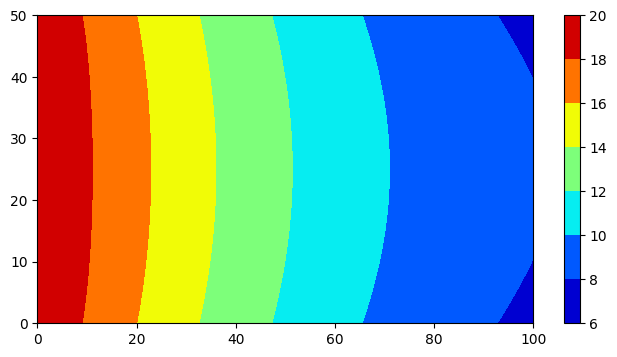

In [ ]:
h,K,G,F,boundary,theta = soln1.fit_ele(mode = "no_source",verbose = False)
plt.figure(figsize=(8,4))
plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta.flatten(),cmap = 'jet')
plt.colorbar()
plt.show()

In [ ]:
gc.collect()

5117

In [ ]:
print(f"The maximum temperature is {np.max(theta):.2f}C and the minimum temperature is {np.min(theta):.2f} C")

The maximum temperature is 630.49C and the minimum temperature is 19.63 C


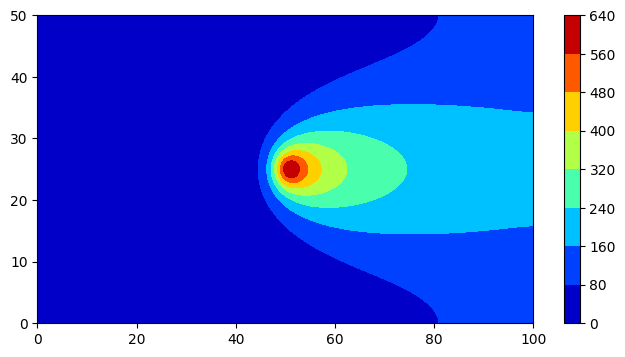

In [ ]:
_,K,G,F,boundary,theta = soln1.fit_ele(mode = "linear",verbose = False)
# h,K,G,F,boundary_term,theta
gc.collect()
plt.figure(figsize=(8,4))
plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta.flatten(),cmap = 'jet')
plt.colorbar()
plt.show()

In [ ]:
gc.collect()

5190

In [ ]:
print(f"The maximum temperature is {np.max(theta):.2f} K and the minimum temperature is {np.min(theta):.2f} K")

The maximum temperature is 630.49 K and the minimum temperature is 19.63 K


## Validation of picard iteration

In [8]:
def Q(point):
    x = point[0,0] #in mm
    return 15e-3*(x/100)*(1-x/100) ## W/mm^3

def k_T(T):
    # return np.ones_like(T)*110
    return (100+0.004*(T-50-273)**2)*1e-3  ##W/mmK

In [9]:
class Picard_valid:
    def __init__(self,nodecoords,elecon):
        self.data_line = {"ips":{2:[-1/np.sqrt(3),1/np.sqrt(3)],3:[-np.sqrt(3/5),0,np.sqrt(3/5)]},\
        "weights":{2:[1,1],3:[5/9,8/9,5/9]}}
        self.data_tle = {"ips":{1:[[1/3,1/3]],3:[[1/6,1/6],[1/6,2/3],[2/3,1/6]]},\
       "weights":{1:[1/2],3:[1/6,1/6,1/6]}}
        self.nodecoords = nodecoords
        self.elecon = elecon
                        
    def fit_ele(self,dt,theta_prev_time = None,theta_prev_pic = None,mode = "linear",scheme = "implicit",verbose = False):
        '''
        Return mass and stiffness matrices alongside the forcing vector
        '''
        gp = 3

        qo = 0   # W/mm^2
        c = 465 #J/kg.K
        rho = 7e-6 #kg/mm^3

        nodes = self.nodecoords
        ele = self.elecon
        
        ln = np.where(nodes[:,0] == 0)[0]
        rn = np.where(nodes[:,0] == np.max(nodes[:,0]))[0]
        bn = np.where(nodes[:,1] == 0)[0]
        tn = np.where(nodes[:,1] == np.max(nodes[:,1]))[0]
        
        nop = nodes.shape[0]
        ips = np.array(self.data_tle["ips"][gp])
        weights = np.array(self.data_tle["weights"][gp])

        K_row,K_col,K_data = [],[],[]
        M_row,M_col,M_data = [],[],[]

        #Parallel processing for matrix computations
        items = [(nodes,elei,theta_prev_time,theta_prev_pic,mode,scheme) for elei in ele]
        st = time.time()
        with Pool(processes = 4) as pool:
            results = pool.map(picard_helper, items)
        if verbose == True:
            print(f"Time for pooling to end {time.time()-st}")

        #Accumulating data collected over multiprocessing
        st = time.time()
        K_row, K_col, K_data, M_row, M_col, M_data, F_row,F_data,areas = list(zip(*results))
        mega = [K_row, K_col, K_data, M_row, M_col, M_data, F_row,F_data]
        K_row, K_col, K_data, M_row, M_col, M_data, F_row,F_data = [flatten(mini) for mini in mega]
        if verbose == True:
            print(f"Time for accumulation of data to end {time.time()-st}")

        #Preparing the matrices for calculations
        st = time.time()
        F= coo_array((F_data,(F_row,[0]*len(F_row))),shape = ((nop,1))).toarray()
        
        K_sparse = coo_array((K_data,(K_row,K_col)),shape=(nop,nop))
        M_sparse = coo_array((M_data,(M_row,M_col)),shape=(nop,nop))
        if verbose == True:
            print(f"Time for matrices creation {time.time()-st}")

        #Converting sparse to dense matrix for submatrix extractions
        st = time.time()
        K = K_sparse.toarray()
        M = M_sparse.toarray()

        if verbose == True:
            print(f"Time for sparse to dense conversion {time.time()-st}")
        
        #setting up the right hand side
        T_b = 273+100
        non_bn = np.setdiff1d(np.arange(K.shape[0]),bn)
        rhs = (F+M@theta_prev_time/dt)\
               -T_b*np.sum(K[np.ix_(np.arange(K.shape[0]),bn)]+M[np.ix_(np.arange(K.shape[0]),bn)]/dt,axis = 1).reshape(-1,1)
        
        K_sub = K[np.ix_(non_bn,non_bn)]
        M_sub = M[np.ix_(non_bn,non_bn)]
        rhs_sub = rhs[np.ix_(non_bn,[0])]
        theta_sub = np.linalg.inv(K_sub+M_sub/dt)@(rhs_sub)

        theta = np.zeros((K.shape[0],1))+T_b
        theta[non_bn,:] = theta_sub.reshape(-1,1)
        
        return [M,K,F,theta]

In [10]:
def picard(soln,nodecoords,ele_con,theta_init):
    dt = 1
    times = np.arange(0,10,dt)
    theta_prev_time = theta_init
    
    for t in times:
        e = 1e5
        tolerance = 1e-4
        iter = 0
        theta_prev_pic = theta_prev_time
        while(e>tolerance):
            iter +=1
            M,K,F,theta_new = soln.fit_ele(dt,theta_prev_time = theta_prev_time,theta_prev_pic = theta_prev_pic,mode = "non_linear",scheme = "implicit")
            e = np.linalg.norm(theta_new - theta_prev_pic)
            theta_prev_pic = theta_new
            if t == round(t):
                print(f"Error at {iter} iteration at time {t} is {e:.2E}")
        theta_prev_time = theta_new
        
    plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta_new.flatten()-273, cmap = 'jet')
    plt.title(f"Converged solution")
    plt.colorbar()
    plt.show()

    return theta_new
        

In [11]:
mesh_size_factor = 3
filename = f"square_{mesh_size_factor}.msh"
nodecoords,ele_con = createMesh(geo_file='squareDomain.geo',
                                meshFactorForEntireSurface=mesh_size_factor) 
soln3 = Picard_valid(nodecoords,ele_con)
T_b = 273+50
theta_init = np.zeros((nodecoords.shape[0],1))+T_b
theta_final = picard(soln3,nodecoords,ele_con,theta_init)

Reading Mesh.msh
Number of nodes in the mesh: 0
Number of triangles in the mesh: 0



ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
Ta = theta_final[np.where((nodecoords[:,0] == 0) * (nodecoords[:,1] == 100)) [0][0]]-273
Tb = theta_final[np.where((nodecoords[:,0] == 100) * (nodecoords[:,1] == 100)) [0][0]]-273
print(f"The temperature at node a is {Ta[0]:.2f}K and at node b is {Tb[0]:.2f}K")

The temperature at node a is 54.74K and at node b is 54.74K


In [12]:
gc.collect()

1758

## Mesh convergence

In [19]:
# Finding mesh size factor for the adaptive mesh part
mesh_size_factor = 3
areaOfPatchRegion = 12 * 12
area_overall = 100*50
meshFactorsForPatchSurface = np.arange(0.1,0.2,0.01)
hOfPatchArea = []
h = []
for meshFactorForPatchSurface in meshFactorsForPatchSurface:
    nodecoords,ele_con = createMesh(geo_file='rectange.geo',
                                        meshFactorForEntireSurface=mesh_size_factor,
                                        meshFactorForAdaptiveSurface=meshFactorForPatchSurface,
                                        xSource=50,
                                        ySource=25,
                                        isMeshRectangle=True
                                    )
    nodesInPatchArea = np.where((np.max(nodecoords[ele_con-1][:,:,0],axis=1)<56)*(np.min(nodecoords[ele_con-1][:,:,0],axis=1)>44)*(np.max(nodecoords[ele_con-1][:,:,1],axis=1)<31)*(np.min(nodecoords[ele_con-1][:,:,1],axis=1)>19))[0]
    hOfPatchArea.append((areaOfPatchRegion / len(nodesInPatchArea))**.5)
    h.append((area_overall / len(nodecoords))**.5)

Reading Mesh.msh
Number of nodes in the mesh: 15111
Number of triangles in the mesh: 30118

Reading Mesh.msh
Number of nodes in the mesh: 12606
Number of triangles in the mesh: 25108

Reading Mesh.msh
Number of nodes in the mesh: 10852
Number of triangles in the mesh: 21600

Reading Mesh.msh
Number of nodes in the mesh: 9275
Number of triangles in the mesh: 18446

Reading Mesh.msh
Number of nodes in the mesh: 8088
Number of triangles in the mesh: 16072

Reading Mesh.msh
Number of nodes in the mesh: 7136
Number of triangles in the mesh: 14168

Reading Mesh.msh
Number of nodes in the mesh: 6390
Number of triangles in the mesh: 12676

Reading Mesh.msh
Number of nodes in the mesh: 5614
Number of triangles in the mesh: 11124

Reading Mesh.msh
Number of nodes in the mesh: 5120
Number of triangles in the mesh: 10136

Reading Mesh.msh
Number of nodes in the mesh: 4616
Number of triangles in the mesh: 9128



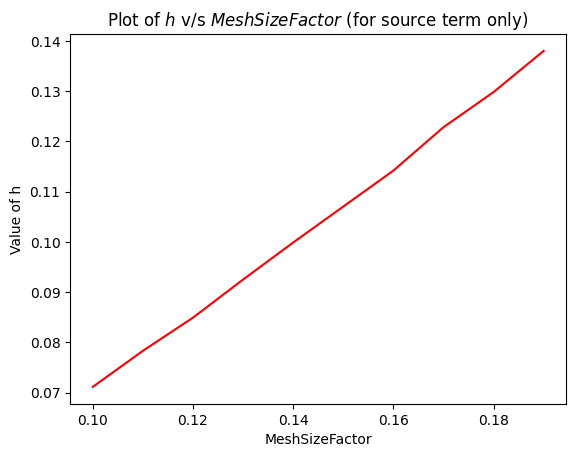

In [14]:
plt.plot(meshFactorsForPatchSurface,hOfPatchArea,'r')
plt.xlabel('MeshSizeFactor')
plt.ylabel('Value of h')
plt.title('Plot of $h$ v/s $Mesh Size Factor$ (for source term only)')
plt.show()

In [15]:
print(f'Value of h for mesh size factor 0.15 is '+str(hOfPatchArea[5]))

Value of h for mesh size factor 0.15 is 0.10702347787777115


In [16]:
gc.collect()

4344

1
Reading Mesh.msh
Number of nodes in the mesh: 12958
Number of triangles in the mesh: 25614

Time for pooling to end 11.798809289932251
Time for accumulation of data to end 0.1577603816986084
Mesh size is 0.44182094433965835 mm
Spot radius is 2 mm
Time for matrices creation 0.656876802444458
Time for sparse to dense conversion 0.29969310760498047
Time for inversion 4.4111833572387695


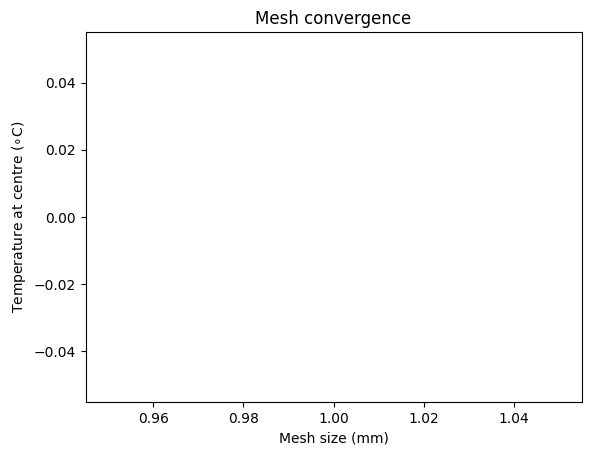

In [22]:
# mesh convergence for the coarser part given that for finer the factor is 0.15

# mesh_size_factors = np.array([1]+ np.arange(5,50,5).tolist())
mesh_size_factors = [1]
meshFactorForAdaptiveSurface = 0.15
rep = np.array([50,25,0]).reshape(1,-1)
mesh_sizes = []
T_reps = []
numberOfEles = []
for mesh_size_factor in mesh_size_factors:
    print(mesh_size_factor)
    nodecoords,ele_con = createMesh(geo_file='rectange.geo',
                                    meshFactorForEntireSurface=mesh_size_factor,
                                    meshFactorForAdaptiveSurface=meshFactorForAdaptiveSurface,
                                    xSource=50,
                                    ySource=25,
                                    isMeshRectangle=True
                                )
    soln1 = FEM(nodecoords,ele_con,np.array([[50,25]]))
    h,K,G,F,boundary,theta = soln1.fit_ele(mode = "linear",verbose = True)
    mesh_sizes.append(h)

    distances = np.sum(np.square(nodecoords-rep),axis = 1)
    closest = np.argmin(distances)
    T_reps.append(theta[closest])
    numberOfEles.append(len(ele_con))

plt.plot(mesh_size_factors,T_reps,'r')
plt.title('Mesh convergence')
plt.xlabel('Mesh size (mm)')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()
    

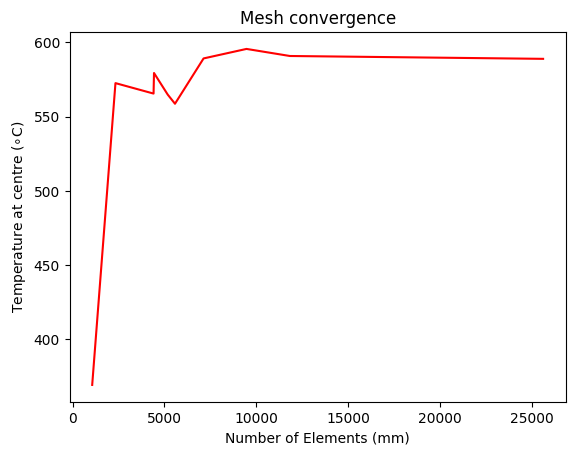

In [31]:
ele = np.argsort(numberOfEles)
plt.plot(np.array(numberOfEles)[ele],np.array(T_reps)[ele],'r')
plt.title('Mesh convergence')
plt.xlabel('Number of Elements (mm)')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()

Slope: [-0.17683745]
Intercept: [6.86657227]


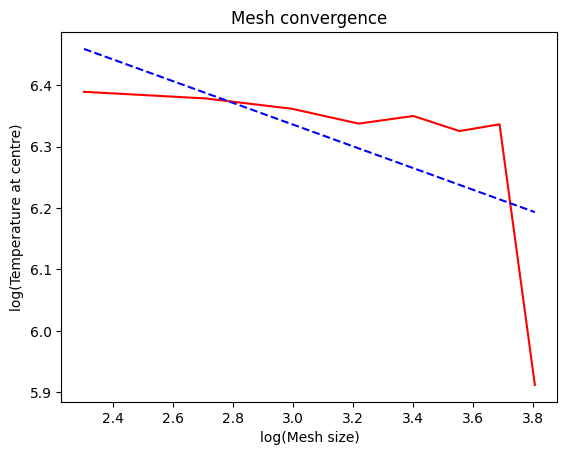

In [53]:
x = np.log(mesh_size_factors[2:])
y = np.log(T_reps[2:])
slope, intercept = np.polyfit(x, y, 1)  # Degree 1 for a linear fit
y_fit = slope * x + intercept
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
plt.plot(x,y,'r',label = 'original')
plt.plot(x,y_fit,'b--',label = 'best_fit')
plt.title('Mesh convergence')
plt.xlabel('log(Mesh size)')
plt.ylabel(r'log(Temperature at centre)')
plt.show()

In [ ]:
gc.collect()

## Final solution

In [6]:
def picard(nodecoords,ele_con,theta_init,source,mode="non_linear"):
## the idea is you initialize a temperature profile and find corresponding multipliers for the non linear terms
    #non is number of nodes
    theta_old = theta_init

    e = 1e5
    tolerance = 1e-4
    iter = 0
    
    while(e>tolerance):
        iter +=1
        _,_,_,_,_,theta_new = FEM(nodecoords,ele_con,source).fit_ele(theta_prev_time = theta_init,theta_prev_pic = theta_old,mode = mode)
        e = np.linalg.norm(theta_new - theta_old) 
        
        theta_old = theta_new
        print(f"Error at {iter} iteration is {e:.2E}")
        # print(theta_init)
    plt.figure(figsize=(8,4))
    plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta_new.flatten(),cmap='jet')
    plt.title(f"Source at {source[0,0],source[0,1]}")
    plt.colorbar()
    plt.show()

    return theta_new

Reading Mesh.msh
Number of nodes in the mesh: 13015
Number of triangles in the mesh: 25728

Reading Mesh.msh
Number of nodes in the mesh: 13015
Number of triangles in the mesh: 25728

Time is 12.5 seconds
Error at 1 iteration is 5.24E+04
Error at 2 iteration is 6.34E+01
Error at 3 iteration is 3.43E-02
Error at 4 iteration is 1.14E-05


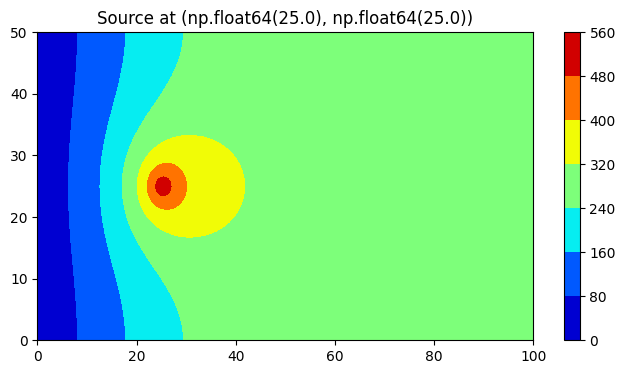

Reading Mesh.msh
Number of nodes in the mesh: 12958
Number of triangles in the mesh: 25614

Reading Mesh.msh
Number of nodes in the mesh: 12958
Number of triangles in the mesh: 25614

Time is 25 seconds
Error at 1 iteration is 4.42E+04
Error at 2 iteration is 5.26E+01
Error at 3 iteration is 2.52E-02
Error at 4 iteration is 6.43E-06


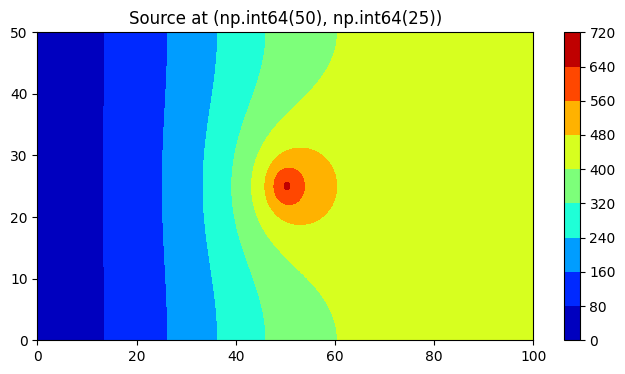

Reading Mesh.msh
Number of nodes in the mesh: 13093
Number of triangles in the mesh: 25884

Reading Mesh.msh
Number of nodes in the mesh: 13093
Number of triangles in the mesh: 25884

Time is 37.5 seconds
Error at 1 iteration is 4.57E+04
Error at 2 iteration is 3.65E+01
Error at 3 iteration is 1.44E-02
Error at 4 iteration is 3.67E-06


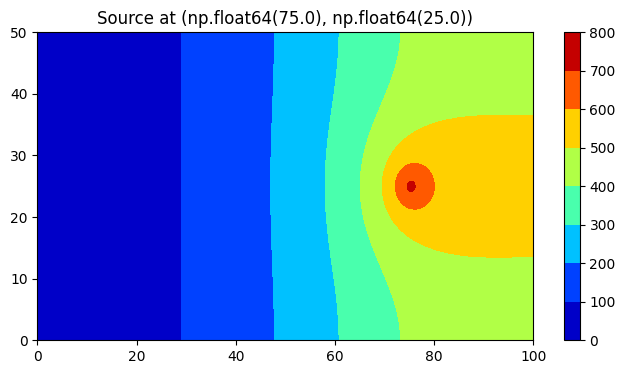

Reading Mesh.msh
Number of nodes in the mesh: 9493
Number of triangles in the mesh: 18610



In [56]:
# Final solution for Titanium alloy with assumed properties and no physical modelling
T_l = 273+500
vo = 2 #mm/s
t_final = 10
times = [12.5,25,37.5]
convergedMeshFactorForEntireSurface = 1
x_source = 0
nodecoords,ele_con = createMesh(geo_file='rectange.geo',
                                    meshFactorForEntireSurface=convergedMeshFactorForEntireSurface,
                                    meshFactorForAdaptiveSurface=meshFactorForAdaptiveSurface,
                                    xSource=x_source +times[0]*vo,
                                    ySource=25,
                                    isMeshRectangle=True)

theta_init = np.zeros((nodecoords.shape[0],1))+T_l
theta_prev = theta_init
#Let's move the source
for i,t in enumerate(times):
    nodecoords,ele_con = createMesh(geo_file='rectange.geo',
                                    meshFactorForEntireSurface=convergedMeshFactorForEntireSurface,
                                    meshFactorForAdaptiveSurface=meshFactorForAdaptiveSurface,
                                    xSource=x_source+vo*t,
                                    ySource=25,
                                    isMeshRectangle=True
                                )
    print(f"Time is {t} seconds")
    theta_final = picard(nodecoords,ele_con,theta_prev,source = np.array([[x_source+vo*t,25]]))
    nodecoords,_ = createMesh(geo_file='rectange.geo',
                                    meshFactorForEntireSurface=convergedMeshFactorForEntireSurface,
                                    meshFactorForAdaptiveSurface=meshFactorForAdaptiveSurface,
                                    xSource=x_source+vo*(times[i+1] if i+1 < len(times) else 0),
                                    ySource=25,
                                    isMeshRectangle=True
                                )
    theta_prev = np.zeros((nodecoords.shape[0],1))+T_l

1.5
Reading Mesh.msh
Number of nodes in the mesh: 787
Number of triangles in the mesh: 1470

1.6
Reading Mesh.msh
Number of nodes in the mesh: 706
Number of triangles in the mesh: 1312

1.7000000000000002
Reading Mesh.msh
Number of nodes in the mesh: 613
Number of triangles in the mesh: 1130

1.8000000000000003
Reading Mesh.msh
Number of nodes in the mesh: 555
Number of triangles in the mesh: 1022

1.9000000000000004
Reading Mesh.msh
Number of nodes in the mesh: 539
Number of triangles in the mesh: 992

3.0
Reading Mesh.msh
Number of nodes in the mesh: 221
Number of triangles in the mesh: 388

4.0
Reading Mesh.msh
Number of nodes in the mesh: 140
Number of triangles in the mesh: 238

5.0
Reading Mesh.msh
Number of nodes in the mesh: 96
Number of triangles in the mesh: 156

6.0
Reading Mesh.msh
Number of nodes in the mesh: 80
Number of triangles in the mesh: 130

7.0
Reading Mesh.msh
Number of nodes in the mesh: 60
Number of triangles in the mesh: 92

8.0
Reading Mesh.msh
Number of node

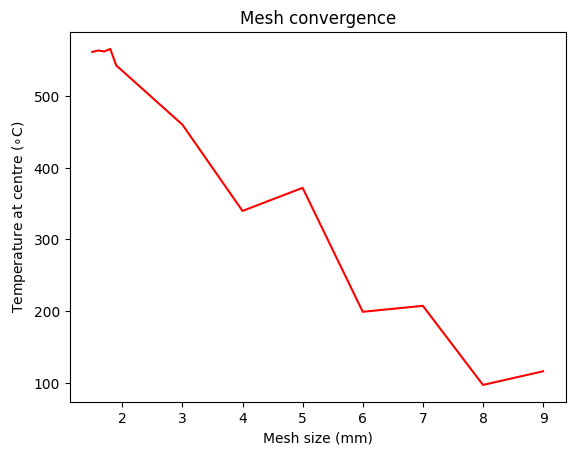

In [14]:
# Normal mesh convergence for phase change consideration of Titanium alloy

mesh_size_factors = np.array(np.arange(1.5,2,0.1).tolist() + np.arange(3,10,1).tolist())
rep = np.array([50,25,0]).reshape(1,-1)
mesh_sizes = []
T_reps = []
numberOfEles = []
for mesh_size_factor in mesh_size_factors:
    print(mesh_size_factor)
    nodecoords,ele_con = createMesh(geo_file='rectange.geo',
                                    meshFactorForEntireSurface=mesh_size_factor,
                                )
    soln1 = FEM(nodecoords,ele_con,np.array([[50,25]]))
    h,K,G,F,boundary,theta = soln1.fit_ele(mode = "linear",verbose = False)
    mesh_sizes.append(h)

    distances = np.sum(np.square(nodecoords-rep),axis = 1)
    closest = np.argmin(distances)
    T_reps.append(theta[closest])
    numberOfEles.append(len(ele_con))

plt.plot(mesh_size_factors,T_reps,'r')
plt.title('Mesh convergence')
plt.xlabel('Mesh size (mm)')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()
    

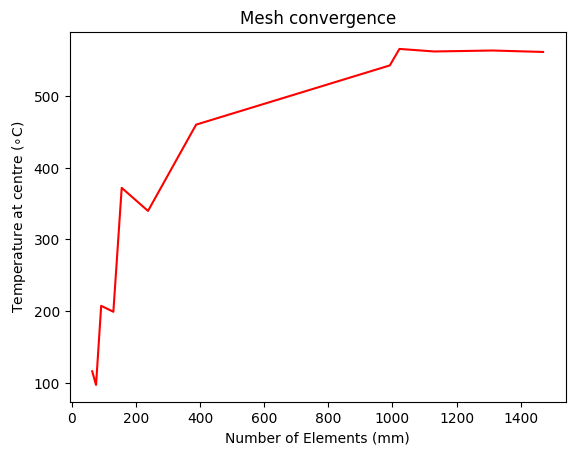

In [15]:
ele = np.argsort(numberOfEles)
plt.plot(np.array(numberOfEles)[ele],np.array(T_reps)[ele],'r')
plt.title('Mesh convergence')
plt.xlabel('Number of Elements (mm)')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()

Slope: [-2.10676639]
Intercept: [9.23036282]


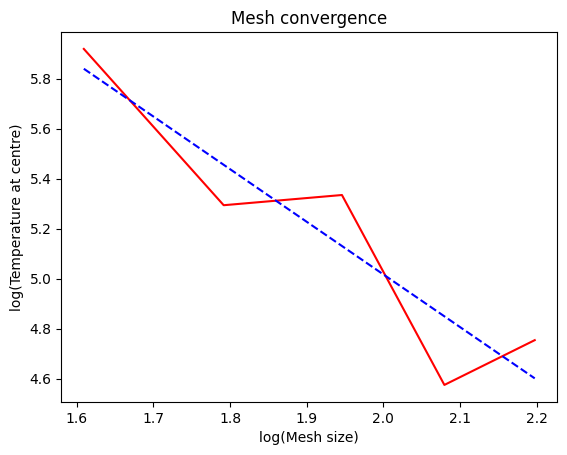

In [21]:
x = np.log(mesh_size_factors[7:])
y = np.log(T_reps[7:])
slope, intercept = np.polyfit(x, y, 1)  # Degree 1 for a linear fit
y_fit = slope * x + intercept
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
plt.plot(x,y,'r',label = 'original')
plt.plot(x,y_fit,'b--',label = 'best_fit')
plt.title('Mesh convergence')
plt.xlabel('log(Mesh size)')
plt.ylabel(r'log(Temperature at centre)')
plt.show()

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 0 seconds
Error at 1 iteration is 2.43E+04
Error at 2 iteration is 3.20E+03
Error at 3 iteration is 4.96E+02
Error at 4 iteration is 1.31E+02
Error at 5 iteration is 1.81E+01
Error at 6 iteration is 4.89E+00
Error at 7 iteration is 6.55E-01
Error at 8 iteration is 1.80E-01
Error at 9 iteration is 2.40E-02
Error at 10 iteration is 6.33E-03
Error at 11 iteration is 8.84E-04
Error at 12 iteration is 2.15E-04
Error at 13 iteration is 3.23E-05


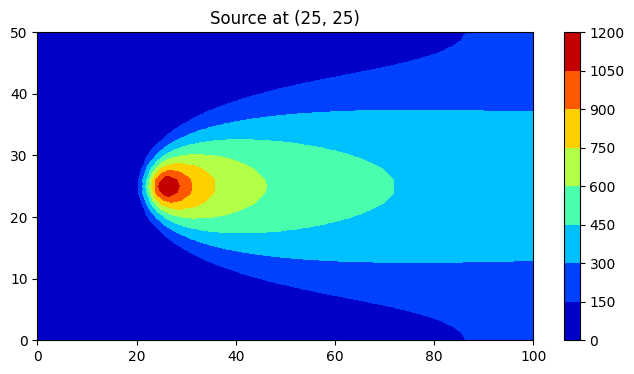

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 2 seconds
Error at 1 iteration is 2.96E+03
Error at 2 iteration is 1.56E+03
Error at 3 iteration is 2.57E+02
Error at 4 iteration is 8.29E+01
Error at 5 iteration is 1.16E+01
Error at 6 iteration is 3.56E+00
Error at 7 iteration is 5.10E-01
Error at 8 iteration is 1.37E-01
Error at 9 iteration is 2.16E-02
Error at 10 iteration is 4.83E-03
Error at 11 iteration is 8.69E-04
Error at 12 iteration is 1.62E-04
Error at 13 iteration is 3.31E-05


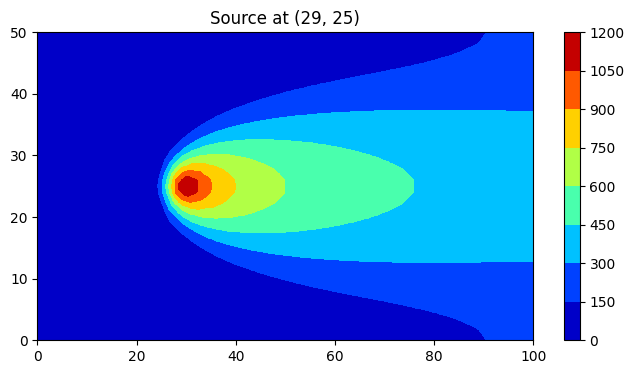

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 4 seconds
Error at 1 iteration is 2.98E+03
Error at 2 iteration is 1.53E+03
Error at 3 iteration is 2.53E+02
Error at 4 iteration is 8.10E+01
Error at 5 iteration is 1.14E+01
Error at 6 iteration is 3.48E+00
Error at 7 iteration is 4.98E-01
Error at 8 iteration is 1.34E-01
Error at 9 iteration is 2.11E-02
Error at 10 iteration is 4.74E-03
Error at 11 iteration is 8.47E-04
Error at 12 iteration is 1.60E-04
Error at 13 iteration is 3.23E-05


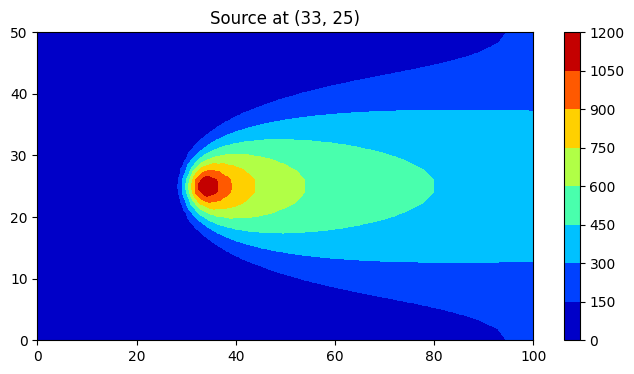

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 6 seconds
Error at 1 iteration is 2.95E+03
Error at 2 iteration is 1.51E+03
Error at 3 iteration is 2.50E+02
Error at 4 iteration is 7.90E+01
Error at 5 iteration is 1.11E+01
Error at 6 iteration is 3.37E+00
Error at 7 iteration is 4.80E-01
Error at 8 iteration is 1.29E-01
Error at 9 iteration is 2.01E-02
Error at 10 iteration is 4.55E-03
Error at 11 iteration is 7.96E-04
Error at 12 iteration is 1.53E-04
Error at 13 iteration is 3.00E-05


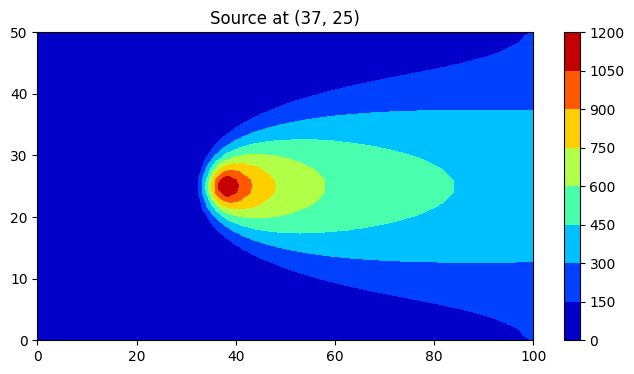

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 8 seconds
Error at 1 iteration is 2.90E+03
Error at 2 iteration is 1.48E+03
Error at 3 iteration is 2.47E+02
Error at 4 iteration is 7.67E+01
Error at 5 iteration is 1.08E+01
Error at 6 iteration is 3.26E+00
Error at 7 iteration is 4.65E-01
Error at 8 iteration is 1.24E-01
Error at 9 iteration is 1.91E-02
Error at 10 iteration is 4.36E-03
Error at 11 iteration is 7.46E-04
Error at 12 iteration is 1.45E-04
Error at 13 iteration is 2.76E-05


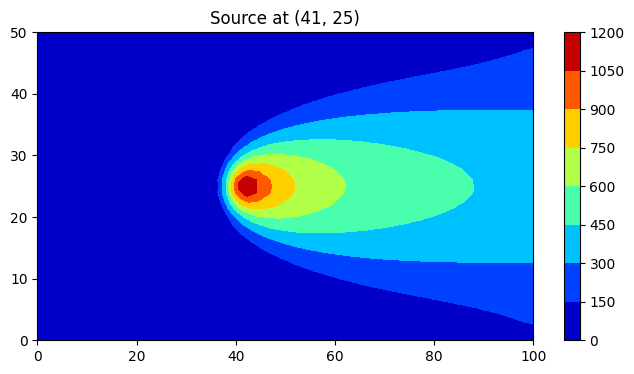

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 10 seconds
Error at 1 iteration is 2.89E+03
Error at 2 iteration is 1.45E+03
Error at 3 iteration is 2.46E+02
Error at 4 iteration is 7.45E+01
Error at 5 iteration is 1.07E+01
Error at 6 iteration is 3.17E+00
Error at 7 iteration is 4.55E-01
Error at 8 iteration is 1.21E-01
Error at 9 iteration is 1.87E-02
Error at 10 iteration is 4.25E-03
Error at 11 iteration is 7.25E-04
Error at 12 iteration is 1.42E-04
Error at 13 iteration is 2.68E-05


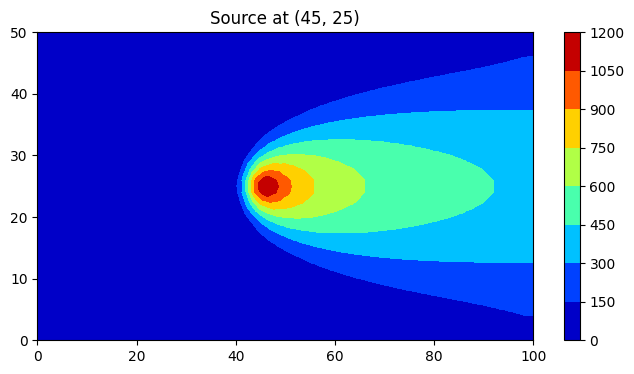

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 12 seconds
Error at 1 iteration is 2.84E+03
Error at 2 iteration is 1.43E+03
Error at 3 iteration is 2.42E+02
Error at 4 iteration is 7.25E+01
Error at 5 iteration is 1.04E+01
Error at 6 iteration is 3.08E+00
Error at 7 iteration is 4.45E-01
Error at 8 iteration is 1.18E-01
Error at 9 iteration is 1.83E-02
Error at 10 iteration is 4.21E-03
Error at 11 iteration is 7.19E-04
Error at 12 iteration is 1.43E-04
Error at 13 iteration is 2.69E-05


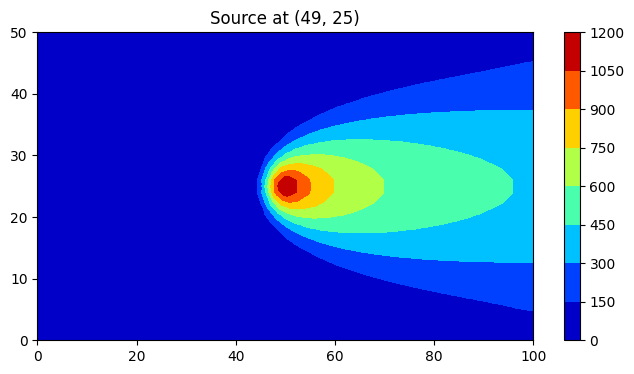

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 14 seconds
Error at 1 iteration is 2.88E+03
Error at 2 iteration is 1.40E+03
Error at 3 iteration is 2.40E+02
Error at 4 iteration is 7.02E+01
Error at 5 iteration is 1.03E+01
Error at 6 iteration is 2.99E+00
Error at 7 iteration is 4.35E-01
Error at 8 iteration is 1.15E-01
Error at 9 iteration is 1.78E-02
Error at 10 iteration is 4.15E-03
Error at 11 iteration is 6.99E-04
Error at 12 iteration is 1.43E-04
Error at 13 iteration is 2.63E-05


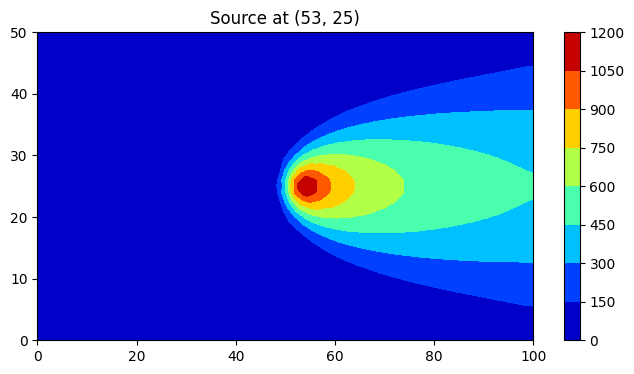

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 16 seconds
Error at 1 iteration is 2.90E+03
Error at 2 iteration is 1.36E+03
Error at 3 iteration is 2.36E+02
Error at 4 iteration is 6.73E+01
Error at 5 iteration is 9.94E+00
Error at 6 iteration is 2.85E+00
Error at 7 iteration is 4.16E-01
Error at 8 iteration is 1.10E-01
Error at 9 iteration is 1.68E-02
Error at 10 iteration is 3.92E-03
Error at 11 iteration is 6.51E-04
Error at 12 iteration is 1.34E-04
Error at 13 iteration is 2.42E-05


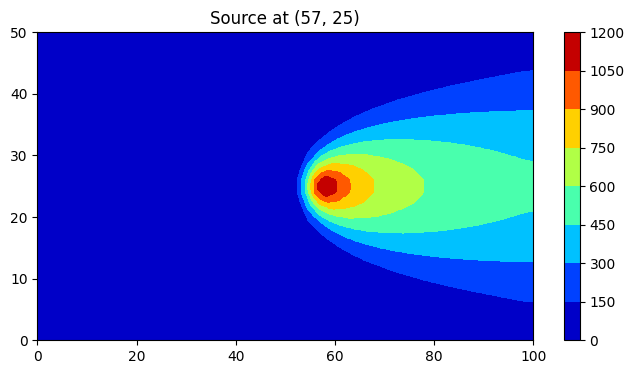

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 18 seconds
Error at 1 iteration is 2.85E+03
Error at 2 iteration is 1.33E+03
Error at 3 iteration is 2.32E+02
Error at 4 iteration is 6.44E+01
Error at 5 iteration is 9.63E+00
Error at 6 iteration is 2.71E+00
Error at 7 iteration is 3.97E-01
Error at 8 iteration is 1.04E-01
Error at 9 iteration is 1.57E-02
Error at 10 iteration is 3.70E-03
Error at 11 iteration is 5.98E-04
Error at 12 iteration is 1.26E-04
Error at 13 iteration is 2.19E-05


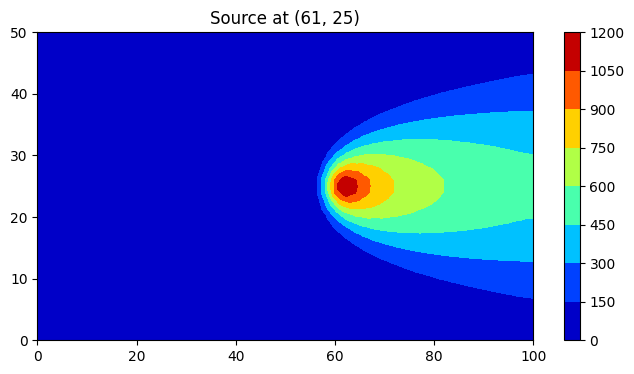

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 20 seconds
Error at 1 iteration is 2.85E+03
Error at 2 iteration is 1.29E+03
Error at 3 iteration is 2.29E+02
Error at 4 iteration is 6.14E+01
Error at 5 iteration is 9.38E+00
Error at 6 iteration is 2.60E+00
Error at 7 iteration is 3.87E-01
Error at 8 iteration is 1.00E-01
Error at 9 iteration is 1.54E-02
Error at 10 iteration is 3.61E-03
Error at 11 iteration is 5.91E-04
Error at 12 iteration is 1.24E-04
Error at 13 iteration is 2.19E-05


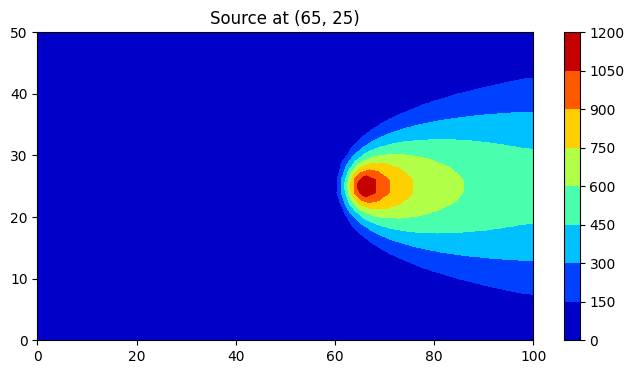

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 22 seconds
Error at 1 iteration is 2.81E+03
Error at 2 iteration is 1.24E+03
Error at 3 iteration is 2.27E+02
Error at 4 iteration is 5.84E+01
Error at 5 iteration is 9.18E+00
Error at 6 iteration is 2.50E+00
Error at 7 iteration is 3.80E-01
Error at 8 iteration is 9.83E-02
Error at 9 iteration is 1.54E-02
Error at 10 iteration is 3.60E-03
Error at 11 iteration is 6.09E-04
Error at 12 iteration is 1.25E-04
Error at 13 iteration is 2.32E-05


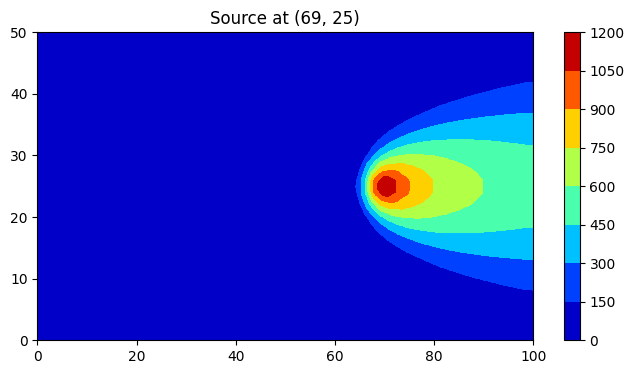

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 24 seconds
Error at 1 iteration is 2.79E+03
Error at 2 iteration is 1.20E+03
Error at 3 iteration is 2.22E+02
Error at 4 iteration is 5.50E+01
Error at 5 iteration is 8.81E+00
Error at 6 iteration is 2.35E+00
Error at 7 iteration is 3.61E-01
Error at 8 iteration is 9.28E-02
Error at 9 iteration is 1.46E-02
Error at 10 iteration is 3.43E-03
Error at 11 iteration is 5.76E-04
Error at 12 iteration is 1.21E-04
Error at 13 iteration is 2.22E-05


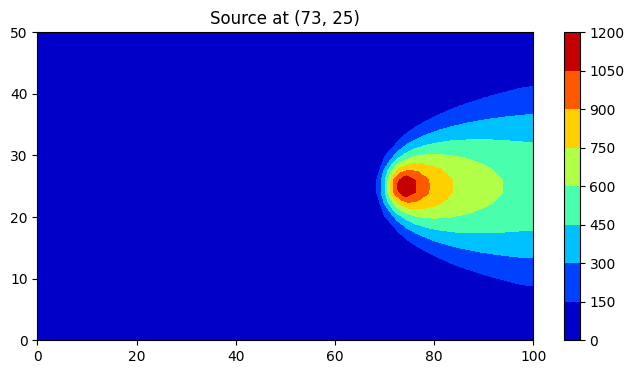

In [32]:
nodecoords,ele_con = createMesh(geo_file='rectange.geo',
                                meshFactorForEntireSurface=1
                                )
T_l = 273+500
vo = 2 #mm/s
t_final = 25
times = np.arange(0,t_final,2)
theta_init = np.zeros((nodecoords.shape[0],1))+T_l
theta_prev = theta_init
#Let's move the source
x_source = 25
for t in times:
    nodecoords,ele_con = createMesh(geo_file='rectange.geo',
                                    meshFactorForEntireSurface=1
                                )
    print(f"Time is {t} seconds")
    theta_final = picard(nodecoords,ele_con,theta_prev,source = np.array([[x_source+vo*t,25]]),mode="phase_change")
    theta_prev = theta_final